In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arima import arima
import urllib.request

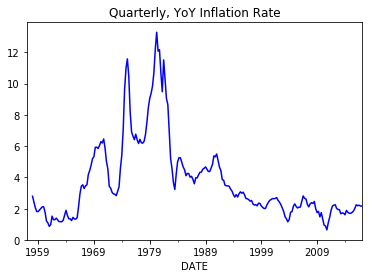

In [2]:
# Download Core CPI data from FRED
url = 'https://fred.stlouisfed.org/series/CPILFESL/downloaddata/CPILFESL.csv'
source = urllib.request.urlopen(url).read().decode('utf-8').split("\n")
df_monthly = pd.read_csv(url, header=0, parse_dates=[0], index_col=0, squeeze=True)

# Monthly to Quarterly
resample = df_monthly.resample('Q')
df_quarterly = resample.mean()

# Year over Year growth
df_yoy = df_quarterly.pct_change(periods=4)*100

# Convert to numpy
pi=df_yoy.values
pi = pi[4:,]

# Plot data
plt.figure()
df_yoy.plot(style='b')
plt.title('Quarterly, YoY Inflation Rate')
plt.show()

In [3]:
# IMA(1,1)

p = 0
d = 1
q = 1

# Model Instance
ima = arima(p, d, q, pi)

# Estimate the IMA model using maximum likelihood
phi, theta, L, epsilon, v2 = ima()

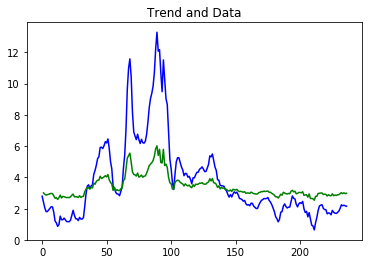

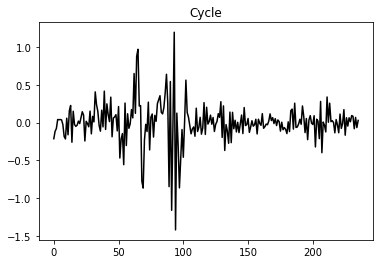

In [4]:
# Beveridge Nelson Decomposition

# cycle: c_{t} = theta * epsilon_{t}
c = theta * epsilon

# trend: z_{t} = z_[t-1] + (1-theta) * epsilon_{t}
z = np.empty_like(c)
z[0] = pi[0] - c[0]

for i in range(1,len(z)):
    z[i] = z[i-1] + (1-theta) * epsilon[i]
    
# get the same shape as pi
z = np.append(np.nan, z)

# Plot trend
plt.figure()
plt.plot(pi, color='b')
plt.plot(z, color='g')
plt.title('Trend and Data')
plt.show()

# Plot cycle
plt.figure()
plt.plot(c,  color = 'k')
plt.title('Cycle')
plt.show()